# RNN/LSTM techniques to predict time-series data

There has been an increased on the use of Deep Learning techniques to predict anomalies using time series data. Some of the most common methods used and tested in the field are:

* Denoising Deep Autoencoders.
* GANs.
* RNN/LSTM.



LSTMs have been proved to be an option for anomaly detection, as suggested in the following papers:

* [Variational Inference for On-line Anomaly Detection in High-Dimensional Time Series](https://arxiv.org/pdf/1602.07109.pdf)
* [LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection](https://arxiv.org/pdf/1607.00148.pdf)
* [Long Short Term Memory Networks for Anomaly Detection in Time Series](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2015-56.pdf)


This implementation was built using the advise on the following sources: [Keras recurrent tutorial ](https://github.com/Vict0rSch/deep_learning/tree/master/keras/recurrent) and
[Recurrent Keras Power ](https://github.com/Vict0rSch/deep_learning/blob/master/keras/recurrent/recurrent_keras_power.py). Our work is far from being perfect, this is just a demostration on how a LSTM could be used on our dataset, nevertheless for a proper development there are some considerations that need to be taking into account. (i.g., regularisation, optimisation, evaluation, etc.)



In [100]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.preprocessing import StandardScaler

Feature extraction as previously seen.

In [101]:
df = pd.read_csv('machine_temperature_system_failure.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hours'] = df['timestamp'].dt.hour
df['minutes'] = df['timestamp'].dt.minute
df['month'] = df['timestamp'].dt.month
df['quarter'] = df['timestamp'].dt.quarter
df['workingHour'] = ((df['hours'] >= 6) & (df['hours'] <= 19)).astype(int)
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
X = df.drop(['timestamp', 'time_epoch'], 1)

In [51]:
# general hyperparameters
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
#x_train = np.array(X_scaled[0:-prediction_time-testdatacut])
#y_train = np.array(X_scaled[prediction_time:-testdatacut  ][0])

# test data
#x_test = np.array(X_scaled[0-testdatacut:-prediction_time])
#y_test = np.array(X_scaled[prediction_time-testdatacut:  ][0])

In [59]:
#Normalisation
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(X)
data_n = pd.DataFrame(np_scaled)

In [72]:
#train data
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ][0].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ][0].as_matrix()

C:\Users\Diego\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
C:\Users\Diego\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
C:\Users\Diego\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Diego\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Once all the datapoints are loaded as one large timeseries, we have to split it into examples. 

In [71]:
#one example is made of a sequence of 50 values
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

In [73]:
# data sequence reshape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# sanity check
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (21593, 50, 8)
y_train (21593,)
x_test (1000, 50, 8)
y_test (1000,)


The Network will have 1-dimensional input, two hidden layers of sizes 50 and 100 and a 1-dimensional output layer.

In [75]:
model = Sequential()

model.add(LSTM(
            input_dim=x_train.shape[-1],
            output_dim=50,
            return_sequences=True))                
model.add(Dropout(0.2))

model.add(LSTM(
            100,
            return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
            units=1))
model.add(Activation('linear'))


C:\Users\Diego\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Diego\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=True, input_shape=(None, 8))`


In [77]:
#Measuring compilation time
import time
start = time.time()
model.compile(loss='mse', optimizer='rmsprop') #Mean Squared Error is the standard for regression.
print('Compilation time : {}'.format(time.time() - start))

compilation time : 0.09750151634216309


In [78]:
#Model Training
model.fit(
    x_train,
    y_train,
    batch_size=3028,
    nb_epoch=30,
    validation_split=0.1)

C:\Users\Diego\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 19433 samples, validate on 2160 samples
Epoch 1/30
19433/19433 [==============================] - 71s 4ms/step - loss: 0.3474 - val_loss: 0.3254
Epoch 2/30
19433/19433 [==============================] - 64s 3ms/step - loss: 0.0826 - val_loss: 0.1697
Epoch 3/30
19433/19433 [==============================] - 49s 3ms/step - loss: 0.0693 - val_loss: 0.2676
Epoch 4/30
19433/19433 [==============================] - 51s 3ms/step - loss: 0.0658 - val_loss: 0.0856
Epoch 5/30
19433/19433 [==============================] - 52s 3ms/step - loss: 0.0587 - val_loss: 0.1547
Epoch 6/30
19433/19433 [==============================] - 52s 3ms/step - loss: 0.0567 - val_loss: 0.0638
Epoch 7/30
19433/19433 [==============================] - 54s 3ms/step - loss: 0.0499 - val_loss: 0.0956
Epoch 8/30
19433/19433 [==============================] - 52s 3ms/step - loss: 0.0506 - val_loss: 0.0565
Epoch 9/30
19433/19433 [==============================] - 50s 3ms/step - loss: 0.0441 - val_loss: 0.1169
Epoch 

Due to the high computational power demanded by our model, approx 1hr,  we save the model as a json so we dont have to train it every time

In [79]:
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2.h5")
print("Saved model to disk")

Saved model to disk


In [103]:
from keras.models import model_from_json
json_file = open('model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model2.h5")
print("Loaded model from disk")

Loaded model from disk


In [105]:
# create the list of difference between prediction and test data
diff=[]
ratio=[]

p = loaded_model.predict(x_test)
#predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

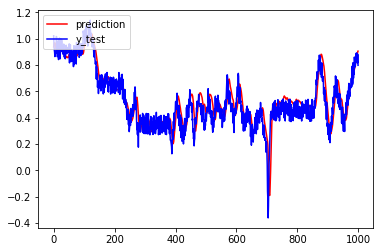

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [109]:
#The datapoins with the highest difference are anomalies.
diff = pd.Series(diff)
number_of_outliers = int(0.01*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
anom_df = complement.append(test, ignore_index='True')
print("There are: {} anomalies.".format(sum(anom_df==1)))

There are: 10 anomalies.


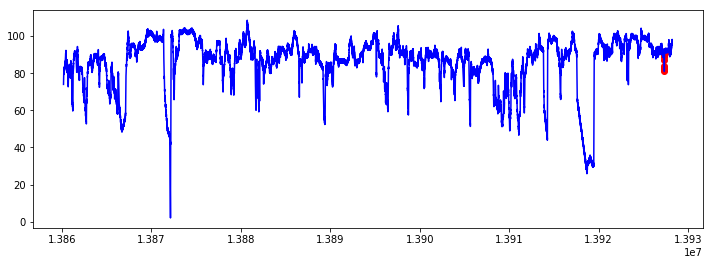

In [110]:
fig, ax = plt.subplots(figsize=(12,4))
a = df.loc[anom_df==1, ['time_epoch', 'value']] #anomaly
ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

# Conclusion

Overall, trainning a Deep Learning algorithms takes a lot of effort and are hard to explain to a layman. The work done has proved a partial functionality of a deep neural network. We have proved the intuition behind a RNN/LSTM implementation, although it requires further fine tunning of the hyperparameters to show proper results.